# LeNet

In [1]:
%matplotlib inline

from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomRotation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.figsize'] = (9, 6)

sns.set_style('darkgrid')

In [2]:
DATA_DIR = "../data"

In [3]:
def num_flat_features(self, x):
    """return the number of flat features from a pytorch variable"""
    return int(np.prod(x.size()[1:]))


## Defining the model

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()  # run initializer on the parent class
        
        # Convolutional Layers
        # 1 image, 6 output channels, 5x5 convolution
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        forward must be overwritten in torch model class
        """
        # Convolutional Layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # add pooling layer
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        x = x.view(-1, 256)  # flatten for fully connected layers

        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
    def __str__(self):
        return "LeNet"


In [5]:
net = LeNet()

In [6]:
print(net)

LeNet


Define loss and optimization algorithms

In [7]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters())

## Data handling

In [8]:
def load_data(training=True):
    transform_ = transforms.Compose(
        [RandomRotation(45),
         RandomCrop(28),
         transforms.ToTensor()]
    )
    data = torchvision.datasets.MNIST(
        root='./data/',
        train=training,
        download=True,
        transform=transform_,
    )

    loader = torch.utils.data.DataLoader(
        data,
        batch_size=4,
        shuffle=True,
        num_workers=2,
    )
   
    return loader

Load the data.
If the data files do not exist, download them.

In [9]:
dataloader = load_data(training=True)

In [10]:
def train(model, data, criterion, optimizer, verbose=False):    
    scores = []
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(dataloader, 0):
        # wrap features as torch Variables
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels)  # optimization
        loss.backward()  # compute back propagation
        optimizer.step()  # update model parameters

        running_loss += loss.data[0]

        if i % 100 == 99:  # print every 2000 mini-batches
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
            accuracy = 100. * correct / total

            scores.append((i+1, running_loss/100, accuracy)) 

            # print results
            if verbose and i % 500 == 499:
                print('Batch: %5d - Loss: %.3f' % (i+1, running_loss/100))
                print("Accuracy: {:.2f}%".format(accuracy))

            running_loss = 0.0    

    print('Finished Training')
        
        
    return scores

In [11]:
def unpack_data(data):
    iterations = [i[0] for i in scores]
    loss_scores = [i[1] for i in scores]
    acc_scores = [i[2] for i in scores]
    
    return iterations, loss_scores, acc_scores
    

In [12]:
def plot_loss(i, loss):
    plt.plot(i, loss);
    plt.title('Loss')
    plt.xlabel('Step')
    plt.y_label('Model Loss')


In [13]:
def plot_accuracy(i, acc):
    plt.plot(i, acc);
    plt.title('Accuracy')
    plt.xlabel('Step')
    plt.y_label('Accuracy')


In [14]:
results = defaultdict(list)

for i in range(1):  # Our Epochs
    print("Model {}...".format(i+1))
    net = LeNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())
    
    scores = train(
        net,  # the model
        dataloader,  # the data provider
        criterion,  # the loss function
        optimizer,  # the optimization algorithm
        verbose=True,  # print results
    )
    step, loss, acc = unpack_data(scores) 
    
    net.zero_grad()
    optimizer.zero_grad()
    
    results['step'].append(step)
    results['loss_scores'].append(loss)
    results['acc_scores'].append(acc)
    results['model_n'].append([i] * len(step))
        
    del net, criterion, optimizer
    

Model 1...
Batch:   500 - Loss: 0.830
Accuracy: 55.00%
Batch:  1000 - Loss: 0.569
Accuracy: 70.00%
Batch:  1500 - Loss: 0.421
Accuracy: 73.33%
Batch:  2000 - Loss: 0.304
Accuracy: 77.50%
Batch:  2500 - Loss: 0.350
Accuracy: 81.00%
Batch:  3000 - Loss: 0.299
Accuracy: 82.50%
Batch:  3500 - Loss: 0.303
Accuracy: 84.29%
Batch:  4000 - Loss: 0.269
Accuracy: 85.62%
Batch:  4500 - Loss: 0.271
Accuracy: 87.22%
Batch:  5000 - Loss: 0.212
Accuracy: 88.00%
Batch:  5500 - Loss: 0.172
Accuracy: 88.64%
Batch:  6000 - Loss: 0.217
Accuracy: 87.92%
Batch:  6500 - Loss: 0.215
Accuracy: 88.46%
Batch:  7000 - Loss: 0.209
Accuracy: 88.93%
Batch:  7500 - Loss: 0.125
Accuracy: 89.67%
Batch:  8000 - Loss: 0.174
Accuracy: 89.69%
Batch:  8500 - Loss: 0.205
Accuracy: 90.00%
Batch:  9000 - Loss: 0.224
Accuracy: 90.28%
Batch:  9500 - Loss: 0.146
Accuracy: 90.26%
Batch: 10000 - Loss: 0.223
Accuracy: 90.50%
Batch: 10500 - Loss: 0.181
Accuracy: 90.95%
Batch: 11000 - Loss: 0.188
Accuracy: 91.14%
Batch: 11500 - Loss: 

In [15]:
# results

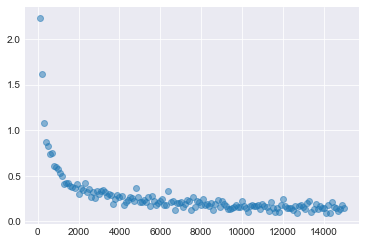

In [22]:
plt.scatter(results['step'], results['loss_scores'], alpha=0.5)

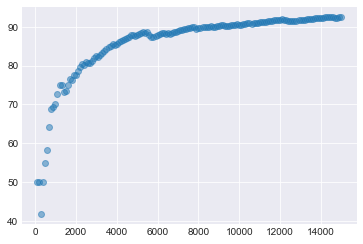

In [23]:
plt.scatter(results['step'], results['acc_scores'], alpha=0.5)

In [18]:
df = pd.DataFrame.from_dict(results)

In [19]:
# df['step'] = df['step'].apply(int)

In [32]:
df.dtypes

acc_scores     object
loss_scores    object
model_n        object
step           object
dtype: object

In [34]:
for i, j in enumerate(df['step']):
    acc = df['acc_scores'][i]
    print(j)
    print(acc)
    
    
    print(len(j),len(acc))
    
    
    
    sns.lmplot(x=j, y=acc, data=df, );

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000]
[50.0, 50.0, 41.666666666666664, 50.0, 55.0, 58.333333333

KeyError: '[   41.66666667    50.            55.            58.33333333\n    64.28571429    68.75          69.44444444    70.\n    72.72727273    73.21428571    73.33333333    75.\n    76.38888889    76.47058824    77.5           77.63157895\n    78.57142857    79.54545455    80.20833333    80.43478261\n    80.55555556    80.76923077    81.            81.25\n    81.89655172    82.25806452    82.5           82.8125\n    83.33333333    83.82352941    84.28571429    84.72222222\n    85.13513514    85.25641026    85.52631579    85.625\n    85.97560976    86.30952381    86.62790698    86.93181818\n    87.22222222    87.28070175    87.5           87.71186441\n    87.75510204    87.76595745    87.91666667    87.94642857\n    88.            88.02083333    88.1147541     88.23529412\n    88.25757576    88.28125       88.30645161    88.42592593\n    88.43283582    88.46153846    88.49206349    88.60294118\n    88.63636364    88.67924528    88.76811594    88.92857143\n    89.08450704    89.23611111    89.38356164    89.52702703\n    89.55696203    89.66666667    89.6875        89.80263158\n    89.81481481    89.88095238    89.93506494    89.93902439\n    89.94252874    90.            90.05681818    90.06024096\n    90.06410256    90.11627907    90.15957447    90.16853933\n    90.26315789    90.27777778    90.32258065    90.36458333\n    90.38461538    90.46391753    90.48913043    90.5\n    90.56122449    90.59405941    90.65656566    90.68627451\n    90.77669903    90.80188679    90.86538462    90.88785047\n    90.95238095    90.97222222    91.05504587    91.13636364\n    91.21621622    91.29464286    91.37168142    91.44736842\n    91.46825397    91.52173913    91.53225806    91.53543307\n    91.59482759    91.6           91.6015625     91.66666667\n    91.73076923    91.73728814    91.79389313    91.80327869\n    91.80672269    91.85606061    91.8699187     91.875\n    91.91729323    91.94214876    91.97761194    92.03703704\n    92.09558824    92.15328467    92.21014493    92.26618705\n    92.32142857    92.34693878    92.37588652    92.39864865\n    92.42957746    92.44966443    92.46575342    92.48251748\n    92.5           92.53472222    92.5862069    100.\n   200.           300.           400.           500.\n   600.           700.           800.           900.\n  1000.          1100.          1200.          1300.\n  1400.          1500.          1600.          1700.\n  1800.          1900.          2000.          2100.\n  2200.          2300.          2400.          2500.\n  2600.          2700.          2800.          2900.\n  3000.          3100.          3200.          3300.\n  3400.          3500.          3600.          3700.\n  3800.          3900.          4000.          4100.\n  4200.          4300.          4400.          4500.\n  4600.          4700.          4800.          4900.\n  5000.          5100.          5200.          5300.\n  5400.          5500.          5600.          5700.\n  5800.          5900.          6000.          6100.\n  6200.          6300.          6400.          6500.\n  6600.          6700.          6800.          6900.\n  7000.          7100.          7200.          7300.\n  7400.          7500.          7600.          7700.\n  7800.          7900.          8000.          8100.\n  8200.          8300.          8400.          8500.\n  8600.          8700.          8800.          8900.\n  9000.          9100.          9200.          9300.\n  9400.          9500.          9600.          9700.\n  9800.          9900.         10000.         10100.\n 10200.         10300.         10400.         10500.\n 10600.         10700.         10800.         10900.\n 11000.         11100.         11200.         11300.\n 11400.         11500.         11600.         11700.\n 11800.         11900.         12000.         12100.\n 12200.         12300.         12400.         12500.\n 12600.         12700.         12800.         12900.\n 13000.         13100.         13200.         13300.\n 13400.         13500.         13600.         13700.\n 13800.         13900.         14000.         14100.\n 14200.         14300.         14400.         14500.\n 14600.         14700.         14800.         14900.\n 15000.        ] not in index'